# Visualize Amazon SageMaker Training Jobs with TensorBoard

This notebook shows how to use TensorBoard to visualize both local and remote training jobs as well as jobs run by Amazon SageMaker Automatic Model Tuning. The notebook uses an external S3 Bucket to store TensorFlow logs. This allows data scientists to use TensorBoard to visualize all past training jobs. TensorBoard can be hosted in SageMaker Notebook Instance, on a local computer or an instance running on AWS.

All TensorFlow logs used by TensorBoard are generated in training script `source_dir/tensorboard_keras_cifar10.py`. It includes code demonstrating how to log accuracy and loss for every epoch during training and validation, calculate and log confusion matrices and images, visualize model architecture, calculate weights distributions and histograms, and compare hyperparameter tuning jobs. The script follows the official [TensorBoard guide](https://www.tensorflow.org/tensorboard/get_started), so you can reference the documentation and easily adjust the code to your needs.

The model used for this notebook is a simple deep CNN that is based on the [Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Code in this notebook is using the latest available version of SageMaker python SDK 1.60.2 and TensorFlow 2.2.0.  

## The dataset
The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

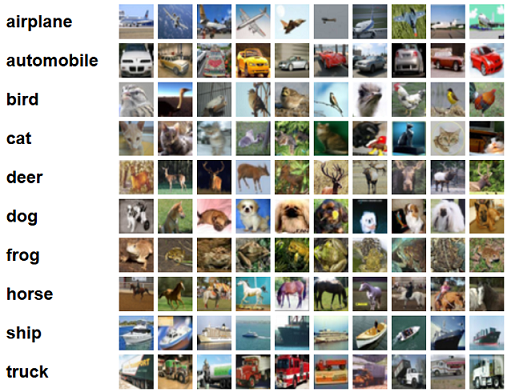

In this tutorial, we will train a deep CNN to recognize these images.

## Set up the environment

This notebook is using the default SageMaker's S3 bucket. Tensorflow logs will be written to `s3://sagemaker-<region>-<account_id>/tensorboard_keras_cifar10/logs`.

In [ ]:
import os
import sagemaker
from sagemaker import get_execution_role
import tensorflow as tf
from tensorflow import keras

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "tensorboard_keras_cifar10"
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)

print("Bucket: {}".format(bucket))
print("SageMaker ver: " + sagemaker.__version__)
print("Tensorflow ver: " + tf.__version__)

## Download the CIFAR-10 dataset
Downloading the test and training data takes around 5 minutes.

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

Converting dataset into [TFRecord files](https://www.tensorflow.org/tutorials/load_data/tfrecord) to allow us to use SageMaker [Pipe Mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/).

In [ ]:
import os

if not os.path.exists("./data/validation"):
    os.makedirs("./data/validation")

if not os.path.exists("./data/train"):
    os.makedirs("./data/train")


def write_tfrecords(x, y, filename):
    writer = tf.io.TFRecordWriter(filename)

    for image, label in zip(x, y):
        example = tf.train.Example(
            features=tf.train.Features(
                feature={
                    "image": tf.train.Feature(
                        bytes_list=tf.train.BytesList(value=[image.tobytes()])
                    ),
                    "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
                }
            )
        )
        writer.write(example.SerializeToString())


write_tfrecords(x_test, y_test, "./data/validation/validation.tfrecords")

write_tfrecords(x_train, y_train, "./data/train/train.tfrecords")

## Create a training job using the sagemaker.TensorFlow estimator, running locally
To test that the code will work in SageMaker, we'll first use SageMaker local mode.

In [ ]:
from sagemaker.tensorflow import TensorFlow

hyperparameters = {"epochs": 2, "batch-size": 128, "tf-logs-path": tensorflow_logs_path}

inputs = {
    "train": "file://" + os.getcwd() + "/data/train",
    "validation": "file://" + os.getcwd() + "/data/validation",
}

estimator = TensorFlow(
    base_job_name="tensorboard-example-local",
    entry_point="tensorboard_keras_cifar10.py",
    source_dir="source_dir",
    role=role,
    framework_version="2.2.0",
    py_version="py37",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="local",
)

estimator.fit(inputs)

## Run on SageMaker cloud

### Uploading the data to s3

In [ ]:
dataset_location = sagemaker_session.upload_data(path="data", key_prefix=prefix + "/data")
display(dataset_location)

### Configuring metrics from the job logs
SageMaker can get training metrics directly from the logs and send them to CloudWatch metrics.

In [ ]:
keras_metric_definition = [
    {"Name": "train:loss", "Regex": ".*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*"},
    {"Name": "train:accuracy", "Regex": ".*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*"},
    {
        "Name": "validation:accuracy",
        "Regex": ".*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*",
    },
    {
        "Name": "validation:loss",
        "Regex": ".*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*",
    },
    {
        "Name": "sec/steps",
        "Regex": ".* (\d+)[mu]s/step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+",
    },
]

### Train image classification based on the cifar10 dataset

We are going to train the model with Pipe Mode input. SageMaker Pipe Mode is a mechanism for providing S3 data to a training job via Linux fifos. Training programs can read from the fifo and get high-throughput data transfer from S3, without managing the S3 access in the program itself.
Pipe Mode is covered in more detail in the SageMaker [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-trainingdata).

In [ ]:
hyperparameters = {"epochs": 2, "batch-size": 256, "tf-logs-path": tensorflow_logs_path}

inputs = {"train": dataset_location + "/train", "validation": dataset_location + "/validation"}

estimator = TensorFlow(
    base_job_name="tensorboard-example",
    entry_point="tensorboard_keras_cifar10.py",
    source_dir="source_dir",
    role=role,
    framework_version="2.2.0",
    py_version="py37",
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    metric_definitions=keras_metric_definition,
    input_mode="Pipe",
)

estimator.fit(inputs, wait=True)

The **```fit```** method will create a training job named **```tensorboard-example-{unique identifier}```** on **ml.c5.xlarge** instance.

These instances will write checkpoints and logs to the S3 bucket we've set up earlier. If you don't have this bucket yet, **```sagemaker_session```** will create it for you. These checkpoints and logs can be used for restoring the training job, and to analyze training job metrics using TensorBoard. 

## Hyperparameter tuning

Next, the tuning job with the following configurations need to be specified:
- hyperparameters that SageMaker Automatic Model Tuning will tune: `learning-rate`, `batch-size` and `optimizer`;
- maximum number of training jobs it will run to optimize the objective metric: `10`
- number of parallel training jobs that will run in the tuning job: `2`
- objective metric that Automatic Model Tuning will use: `validation:accuracy`

In [ ]:
shared_hyperparameters = {"epochs": 6, "tf-logs-path": tensorflow_logs_path}

estimator = TensorFlow(
    base_job_name="tensorboard-example-hpo",
    entry_point="tensorboard_keras_cifar10.py",
    source_dir="source_dir",
    role=role,
    framework_version="2.2.0",
    py_version="py37",
    hyperparameters=shared_hyperparameters,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    metric_definitions=keras_metric_definition,
    input_mode="Pipe",
)

In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.00001, 0.001),
    "batch-size": CategoricalParameter([64, 128, 256, 512]),
    "optimizer": CategoricalParameter(["sgd", "adam", "rmsprop"]),
}

objective_metric_name = "validation:accuracy"

inputs = {"train": dataset_location + "/train", "validation": dataset_location + "/validation"}

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions=keras_metric_definition,
    objective_type="Maximize",
    max_jobs=10,
    max_parallel_jobs=2,
    early_stopping_type="Auto",
    base_tuning_job_name="remote-hpo",
)

tuner.fit(inputs)

# TensorBoard

### Run TensorBoard inside SageMaker Notebooks

Now we can use TensorBoard to compare all training jobs, including local, cloud, tuning training. The following cell will run TensorBoard inside of the SageMaker Notebook Instance.

In [ ]:
aws_region = sagemaker_session.boto_region_name

!AWS_REGION={aws_region} tensorboard --logdir {tensorflow_logs_path}

[**Click here to access TensorBoard instance**](/proxy/6006/)

Instance of TensorBoard will be available at `https://<notebook instance hostname>/proxy/6006/`.
By default TensorBoard assigns port 6006, but if it's already in use TensorBoard will increase the port by 1, so 6007, 6008 and so on until it finds an avilable port.

You should something similar to this:
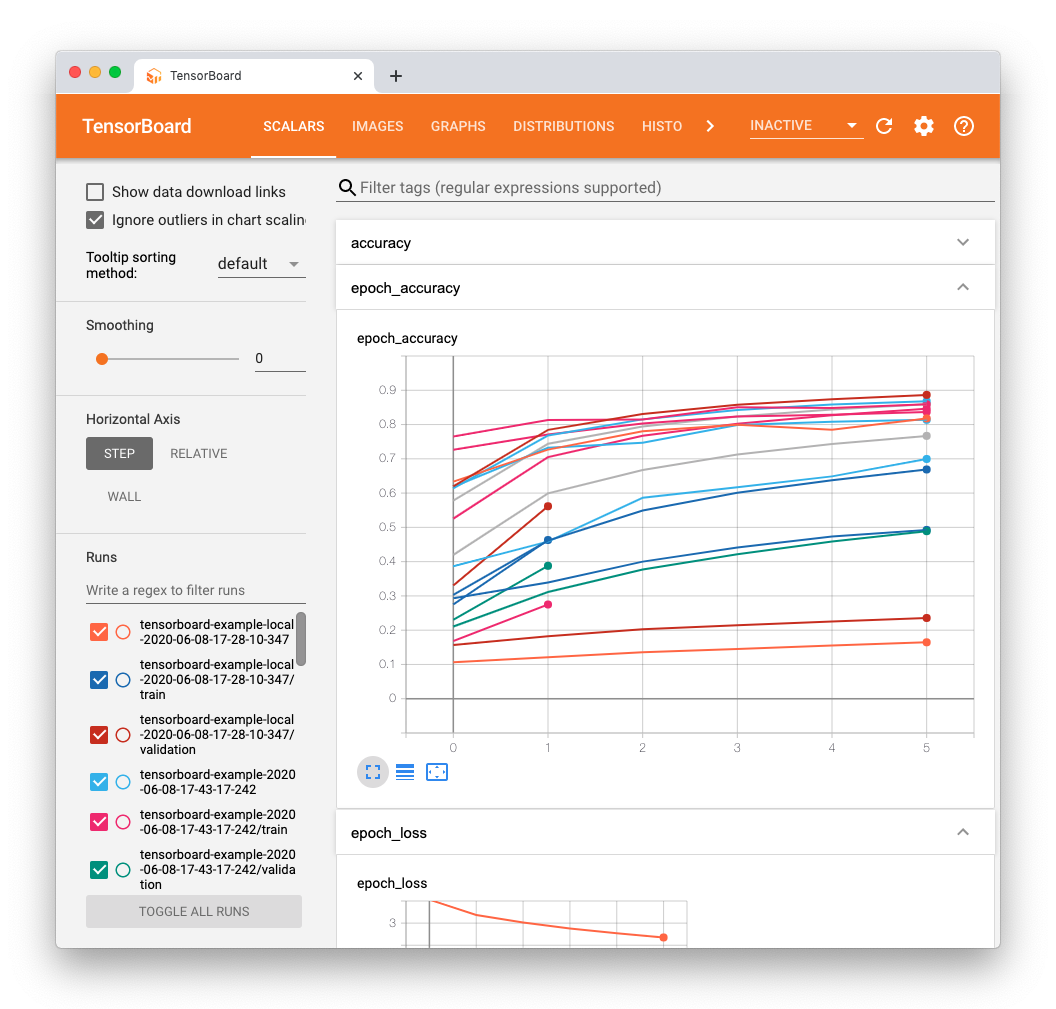


### Run TensorBoard locally

The same command can be used to run TensorBoard in any environment:
- install TensorFlow locally using `pip install tensorflow`
- profiling the model also requires Profiler plugin `pip install tensorboard_plugin_profile`
- configure AWS CLI and make sure you have read access to S3 bucket containing TensorFlow log files
- configure default AWS region. You can do this by setting an environment variable named `AWS_REGION` with region name where the S3 bucket is located, e.g. `export AWS_REGION=eu-west-1`
- start TensorBoard with a following command `tensorboard --logdir <S3_path_to_tensorflow_logs>`

Now you can access the local instance of TensorBoard at http://localhost:6006

# Cleaning up
To avoid incurring charges to your AWS account for the resources used in this tutorial you need to remove all TensorFlow log files and model artifacts from the SageMaker S3 bucket.